In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('CPU')
physical_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
# Import training set
TRAINING_DIR = 'C:/Users/shubham.kumar/pactera_personal/Code_Work/gavin/SFH Aug Dataset - 60-20-20/train'

# Import validation set
VALIDATION_DIR = 'C:/Users/shubham.kumar/pactera_personal/Code_Work/gavin/SFH Aug Dataset - 60-20-20/validation'

# Import test set
TESTING_DIR = 'C:/Users/shubham.kumar/pactera_personal/Code_Work/gavin/SFH Aug Dataset - 60-20-20/test'

In [5]:
# datagen = ImageDataGenerator(
#         rescale=1. / 255,
#         rotation_range=90,
#         width_shift_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

In [6]:
learning_rate = 0.001
epoch = 50
batch_size = 32

In [7]:
#char_name = 'CNN_TL_Approach_1_using_SLGI_and_SFH_Aug_Datasets_TRIAL2'
char_name = 'CNN_TL_Approach_1_using_SLGI_and_SFH_Aug_Datasets_feature_extraction'

char = os.path.join('C:/Users/shubham.kumar/pactera_personal/Code_Work/gavin', char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    shutil.rmtree(char)
    os.mkdir(char)

In [8]:
# Function to reduce learning rate after every 10 epochs
def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))

# Path for h5 file
best_model_address = os.path.join(char, 'CNN_TL_Approach_1_using_SLGI_and_SFH_Aug_Datasets_model.h5')

In [9]:
callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, patience = 3, verbose=1, mode = 'min', restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = 'loss', verbose=1, save_best_only=True, save_weights_only=False, mode = 'min' , period=1)]

In [10]:
'''
def Custom_Model():
    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")
    
    model = keras.models.Sequential()
    for l in range(layer):
        l += 1
        m = (2**l)//2
        for c in range(conv_layer):
            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = 'same', input_shape = (32,32,3), activation = activation))
        model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(dense, activation=activation))
#     model.add(Dropout(dropout))
    model.add(Dense(output_layer, activation=output_activation))
    return model
'''

'\ndef Custom_Model():\n    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")\n    \n    model = keras.models.Sequential()\n    for l in range(layer):\n        l += 1\n        m = (2**l)//2\n        for c in range(conv_layer):\n            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = \'same\', input_shape = (32,32,3), activation = activation))\n        model.add(MaxPooling2D(pool_size = (2, 2)))\n    model.add(Flatten())\n    model.add(Dense(dense, activation=activation))\n#     model.add(Dropout(dropout))\n    model.add(Dense(output_layer, activation=output_activation))\n    return model\n'

In [11]:
output_activation = 'softmax'
losses = 'categorical_crossentropy'
class_mode = 'categorical'
output_layer = 2

In [12]:
optimizer = keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

In [13]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    target_size = (32,32),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              target_size = (32,32),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  target_size = (32,32),
                                                  shuffle=True)

Found 1410 images belonging to 2 classes.
Found 470 images belonging to 2 classes.
Found 472 images belonging to 2 classes.


In [14]:
dense = 128
activation = 'relu'
#dropout = 20 (not used)
#dropout = dropout/100 (not used)

# Within pre-trained model
#layer = 4
#conv_layer = 1
#conv = 16
#conv_size = 3

In [15]:
pretrained_model = load_model("./transfer_learning/CNN_using_SLGI_Dataset/CNN_using_SLGI_Dataset_model.h5")
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [16]:
extracted_features = pretrained_model
extracted_features.pop() # removes the last dense layer
extracted_features.pop() # removes the second last dense layer
extracted_features.pop() # removes the flatten layer
extracted_features.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [17]:
#extracted_features.trainable = False

In [18]:
# for k,v in extracted_features._get_trainable_state().items():
#     k.trainable = False

In [19]:
extracted_features.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [20]:
model = extracted_features

# model.add(Flatten(input_shape=(2, 2, 128), trainable = True))
# model.add(Dense(dense, activation=activation, name = 'dense_2', trainable = True))
# model.add(Dense(output_layer, activation = output_activation, name = 'output', trainable = True))

model.add(Flatten(input_shape=(2, 2, 128)))
model.add(Dense(dense, activation=activation, name = 'dense_2'))
model.add(Dense(output_layer, activation = output_activation, name = 'output'))



model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(),
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [21]:
print("weights:", len(model.weights))
print("trainable_weights:", len(model.trainable_weights))
print("non_trainable_weights:", len(model.non_trainable_weights))

weights: 12
trainable_weights: 12
non_trainable_weights: 0


In [22]:
# count = 1
# for k,v in extracted_features._get_trainable_state().items():
#     if count > 8:
#         k.trainable = True
#     else:
#         k.trainable = False
#     count = count+1

In [23]:
for l in model.layers:
    print(l.name, l.trainable)

conv2d True
max_pooling2d True
conv2d_1 True
max_pooling2d_1 True
conv2d_2 True
max_pooling2d_2 True
conv2d_3 True
max_pooling2d_3 True
flatten True
dense_2 True
output True


In [42]:
#model.summary()

In [24]:
#conv2d
model.get_layer('conv2d').trainable = False
#conv2d_1
model.get_layer('conv2d_1').trainable = False

#conv2d_2
model.get_layer('conv2d_2').trainable = False

#conv2d_3
model.get_layer('conv2d_3').trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [25]:
#model.compile()

In [26]:
for k,v in model._get_trainable_state().items():
    print(k,v)

<tensorflow.python.keras.engine.sequential.Sequential object at 0x000001EEEC431F40> True
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001EEEC442AF0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EEEC442C10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EEEC45C850> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EEEC45C8E0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EEEC4BED60> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EEEC45C2B0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EEEC4CED00> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EEEC4D37F0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EEEC4D3CA0> True
<tensorflow.python.keras.layers.core.Flatten object at 0x000001EEEC549FA0> True
<tensorflow.python.keras.layers.c

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [28]:
with tf.device("/CPU:0"):
    start = time.time()
    history = model.fit_generator(train_generator,
                                        epochs = epoch,
                                        verbose = 1,
                                        callbacks = callback,
                                        validation_data = validation_generator,
                                        shuffle=True)

    end = time.time()
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.7794 - precision: 0.7794 - recall: 0.7794 - true_positives: 1099.0000 - true_negatives: 1099.0000 - false_positives: 311.0000 - false_negatives: 311.0000
Epoch 00001: loss improved from inf to 0.52252, saving model to C:/Users/shubham.kumar/pactera_personal/Code_Work/gavin\CNN_TL_Approach_1_using_SLGI_and_SFH_Aug_Datasets_feature_extraction\CNN_TL_Approach_1_using_SLGI_and_SFH_Aug_Datasets_model.h5
45/45 [==============================] - 3s 61ms/step - loss: 0.5225 - accuracy: 0.7794 - precision: 0.7794 - recall: 0.7794 - true_positives: 1099.0000 - true_negatives: 1099.0000 - false_positives: 311.0000 - false_negatives: 311.0000 - val_loss: 0.2396 - val_accuracy: 0.9064 - val_precision: 0.9064 - val_recall: 0.9064 - val_true_positives: 426.0000 - val_tru

44/45 [============================>.] - ETA: 0s - loss: 0.0072 - accuracy: 0.9985 - precision: 0.9985 - recall: 0.9985 - true_positives: 1376.0000 - true_negatives: 1376.0000 - false_positives: 2.0000 - false_negatives: 2.0000
Epoch 00009: loss improved from 0.02078 to 0.00711, saving model to C:/Users/shubham.kumar/pactera_personal/Code_Work/gavin\CNN_TL_Approach_1_using_SLGI_and_SFH_Aug_Datasets_feature_extraction\CNN_TL_Approach_1_using_SLGI_and_SFH_Aug_Datasets_model.h5
45/45 [==============================] - 2s 45ms/step - loss: 0.0071 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - true_positives: 1408.0000 - true_negatives: 1408.0000 - false_positives: 2.0000 - false_negatives: 2.0000 - val_loss: 0.0237 - val_accuracy: 0.9851 - val_precision: 0.9851 - val_recall: 0.9851 - val_true_positives: 463.0000 - val_true_negatives: 463.0000 - val_false_positives: 7.0000 - val_false_negatives: 7.0000

Epoch 00010: LearningRateScheduler reducing learning rate to 0.001.
Epoch 10/

In [29]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 33.78666973114014 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


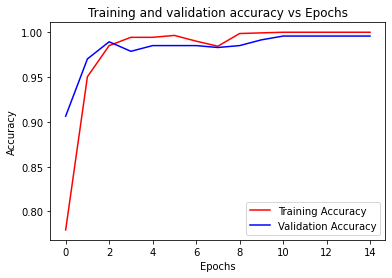

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


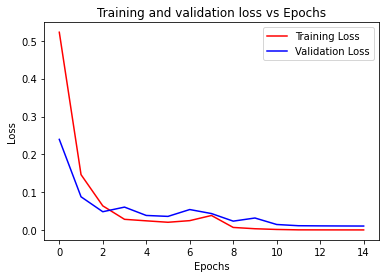

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

# Training and Validation accuracy vs Epochs
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()
accuracy_fig_name = "accuracy.eps"
plt.savefig(os.path.join(char, accuracy_fig_name))
plt.show()


# Training and Validation loss vs Epochs
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()
loss_fig_name = "loss.eps"

plt.savefig(os.path.join(char, loss_fig_name))
plt.show()

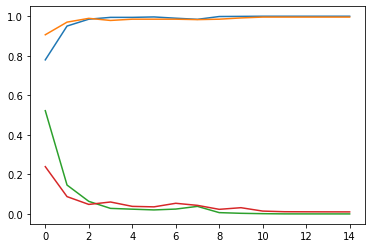

In [31]:
plt.plot(acc)
plt.plot(val_acc)
plt.plot(loss)
plt.plot(val_loss)

In [32]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 100.0 %
The validation accuracy is: 99.57447052001953 %
The test accuracy is: 99.36440587043762 %


In [33]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [34]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("F1-score: {}".format(f1))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

Test Accuracy: 99.36440587043762
Test Precision: 99.36440587043762
Test Recall: 99.36440587043762
True Positive: 469
Test Negetive: 469
False Positive: 3
False Negetive: 3
F1-score: 99.36440587043762
Sensitivity: 99.36440677966102
Specificity: 99.36440677966102


In [35]:
test_class_list = []
for test_name in os.listdir(TESTING_DIR):
    test = os.path.join(TESTING_DIR,test_name)
    test_class_list.append(test)
test_class_list.sort()

In [36]:
def max_pred(pred):
    pred_max = np.argmax(pred)
    return pred_max

In [37]:
y_true = test_generator.classes
labels = validation_generator.class_indices

In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


y_pred = []
for i in range(2):
    for filename in os.listdir(test_class_list[i]):
        file = os.path.join(test_class_list[i], filename)
        img = image.load_img(file, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])

        pred = model.predict(images, batch_size = batch_size)
        pred_max = max_pred(pred)
        
        y_pred.append(pred_max)

print("Calculating CLASSIFICATION REPORT..........:")
classification_report = classification_report(y_true, y_pred, target_names=labels)
print(classification_report)

print("\nCalculating CONFUSION MATRIX, SENSITIVITY (RECALL), PRECISION, SPECIFICITY & F1-SCORE..........:")
cm = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix")
with np.printoptions(threshold=np.inf):
    print(cm)

total = sum(sum(cm))

recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])
precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
f1 = 2*((precision*recall)/(precision+recall))

print("\nsensitivity or recall = {:.4f}".format(recall))
print("precision = {:.4f}".format(precision))
print("specificity = {:.4f}".format(specificity))
print("f1-score = {:.4f}".format(f1))

Calculating CLASSIFICATION REPORT..........:
              precision    recall  f1-score   support

  SFH Sign 1       0.97      1.00      0.98       236
  SFH Sign 2       1.00      0.97      0.98       236

    accuracy                           0.98       472
   macro avg       0.98      0.98      0.98       472
weighted avg       0.98      0.98      0.98       472


Calculating CONFUSION MATRIX, SENSITIVITY (RECALL), PRECISION, SPECIFICITY & F1-SCORE..........:

Confusion Matrix
[[236   0]
 [  8 228]]

sensitivity or recall = 1.0000
precision = 0.9672
specificity = 0.9661
f1-score = 0.9833


In [39]:
# Referenced from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

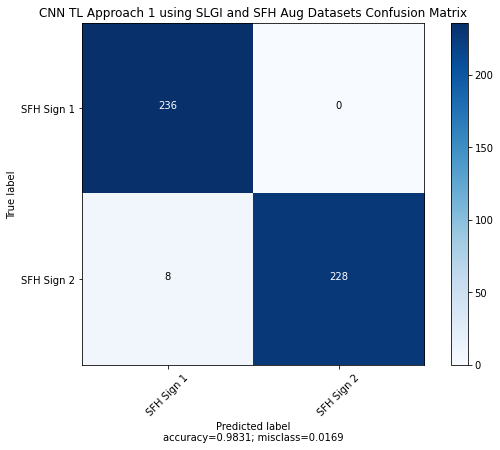

In [40]:
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['SFH Sign 1', 'SFH Sign 2'],
                      title        = "CNN TL Approach 1 using SLGI and SFH Aug Datasets Confusion Matrix")